In [3]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np

In [12]:
train_data = MNIST(
    root="/data/DataSet/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
test_data = MNIST(
    root="/data/DataSet/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
train_data[0][0].shape

torch.Size([1, 32, 32])

In [6]:
labels_map = train_data.class_to_idx
labels_map = dict(zip(labels_map.values(), labels_map.keys()))

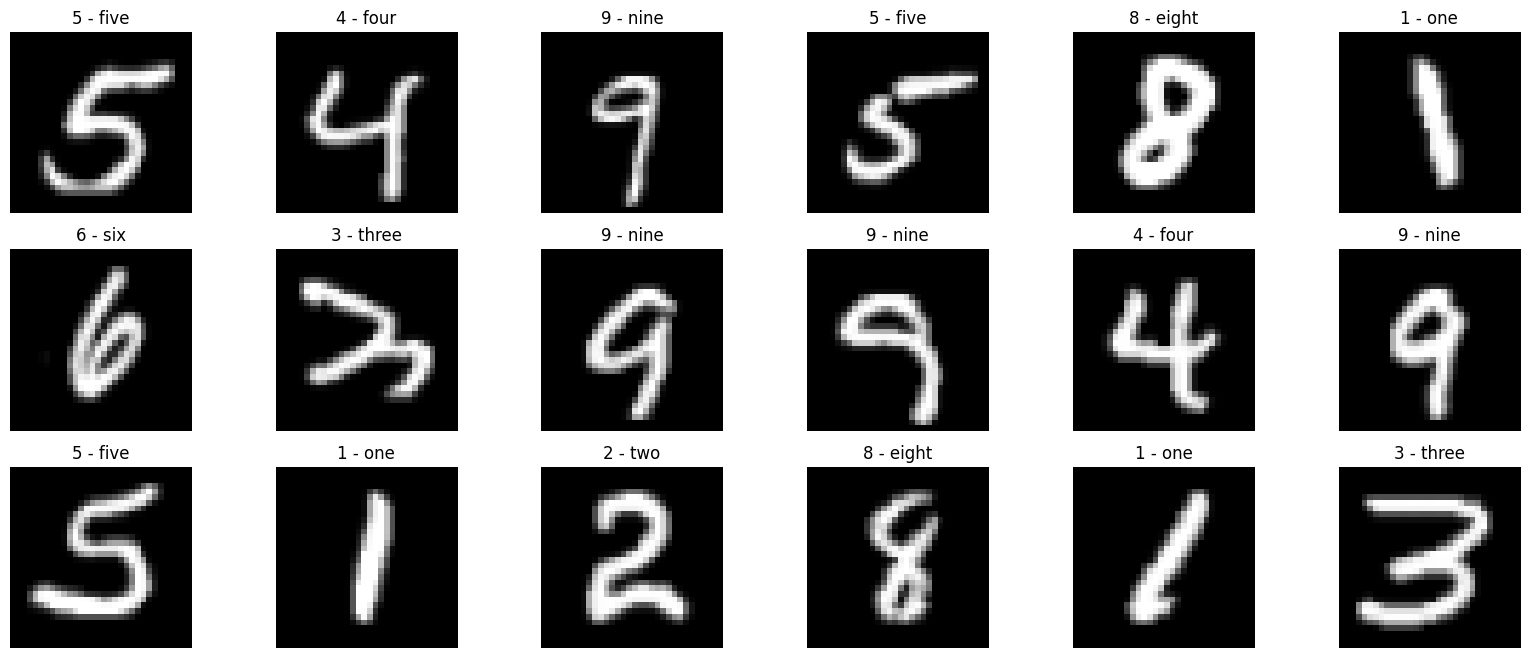

In [7]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]

    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')

plt.show()

In [13]:
from torch import normal

class linear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(linear, self).__init__()

        layers = [
            nn.Linear(
                in_features=in_features,
                out_features=out_features
            )
        ]

        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_features
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class conv(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5, 
        stride: int = 1, 
        padding: int = 0,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(conv, self).__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
        ]
        
        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_channels
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
        
class LeNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super(LeNet, self).__init__()
        
        # 32 -> 28
        self.layer1 = conv(
            in_channels=1,
            out_channels=6
        )

        # 28 -> 14
        self.layer2 = nn.MaxPool2d(2)
        
        # 14 -> 10
        self.layer3 = conv(
            in_channels=6,
            out_channels=16
        )
        
        # 10 -> 5
        self.layer4 = nn.MaxPool2d(2)

        # 400 -> 120
        self.layer5 = linear(
            in_features=400,
            out_features=120,
        )

        self.layer6 = linear(
            in_features=120,
            out_features=84
        )

        self.final = nn.Sequential(
            nn.Linear(
                in_features=84,
                out_features=10
            ),
            nn.Softmax(
                dim=1
            )
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 16*5*5)
        x = self.layer5(x)
        x = self.layer6(x)
        
        return self.final(x)

In [15]:
model = LeNet()
print(model)

LeNet(
  (layer1): conv(
    (model): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layer2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): conv(
    (model): Sequential(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layer4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer5): linear(
    (model): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layer6): linear(
    (model): Sequential(
      (0): Linear(in_features=120, out_features=84, bias=True)
      (1): BatchNorm2d(84, eps=1e-05, mo